### THIS IS A FIRST GLIMPSE OF THE DATA FOR THE PROJECT WIKISPEEDIA

Import Libraries 

In [1]:
import pandas as pd
import tarfile
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse
import requests
from bs4 import BeautifulSoup 
import os

DOWNLOAD THE DATA FROM PYTHON SCRIPT

In [2]:
directory_path = "./data"

# Vérifiez si le répertoire existe déjà
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print("Répertoire data créé")
else:
    print("Le répertoire data existe déjà.")


urls=["https://snap.stanford.edu/data/wikispeedia/wikispeedia_paths-and-graph.tar.gz",
      "https://snap.stanford.edu/data/wikispeedia/wikispeedia_articles_plaintext.tar.gz"]
      #,"https://snap.stanford.edu/data/wikispeedia/wikispeedia_articles_html.tar.gz"]
      #Le dernier lien contient tous les codes htm de tous les articles wikispeedia (très lourd et jsp si on va utiliser ?)

for url in urls:    
    response=requests.get(url)
    if response.status_code==200: #Verify that the response is True
        save_path="./data/"+url[43:]
        with open(save_path,"wb")as f:
            f.write(response.content)
            print(save_path+" downloaded")

PATH=["./data/wikispeedia_paths-and-graph.tar.gz",
    "./data/wikispeedia_articles_plaintext.tar.gz"]

DEST=["./data/wikispeedia_paths-and-graph",
      "./data/wikispeedia_articles_plaintext"]

for i,path in enumerate(PATH):
    with tarfile.open(path,"r:gz") as fichier:
        fichiers_names=fichier.getnames()
        for name in fichiers_names:
            fichier.extract(name, DEST[i])
        
for path in PATH:
    os.remove(path)

Le répertoire data existe déjà.
./data/wikispeedia_paths-and-graph.tar.gz downloaded
./data/wikispeedia_articles_plaintext.tar.gz downloaded


Utilisation des données sur les finished paths

In [3]:
PATH="./data/wikispeedia_paths-and-graph/wikispeedia_paths-and-graph/paths_finished.tsv"
PATH_UNFINISHED = "./data/wikispeedia_paths-and-graph/wikispeedia_paths-and-graph/paths_unfinished.tsv"


finished_path=pd.read_csv(PATH, header=14, delimiter="\t", names=["hashedIpAddress","timestamp","durationInSec","path","rating"])
unfinished_path=pd.read_csv(PATH_UNFINISHED, header=16, delimiter="\t", names=["hashedIpAddress","timestamp","durationInSec","path_start","path_goal","rating"])
finished_path["timestamp"]=pd.to_datetime(finished_path["timestamp"], unit ='s') #convertir le timestamp to datetime
unfinished_path["timestamp"]=pd.to_datetime(unfinished_path["timestamp"], unit ='s') #convertir le timestamp to datetime
finished_path.head()
unfinished_path.head()
print(f"Finished paths : First date {finished_path.timestamp.dt.date.min()} \t Last Date {finished_path.timestamp.dt.date.max()} ")
print(f"Unfinished paths : First date {unfinished_path.timestamp.dt.date.min()} \t Last Date {unfinished_path.timestamp.dt.date.max()} ")


Finished paths : First date 2008-08-18 	 Last Date 2014-01-15 
Unfinished paths : First date 2011-02-07 	 Last Date 2014-01-15 


                            Name  Count
0  Actors_models_and_celebrities     25
1                        Artists     36
2     Astronomers_and_physicists     21
3                       Chemists      8
4               Computing_People      9


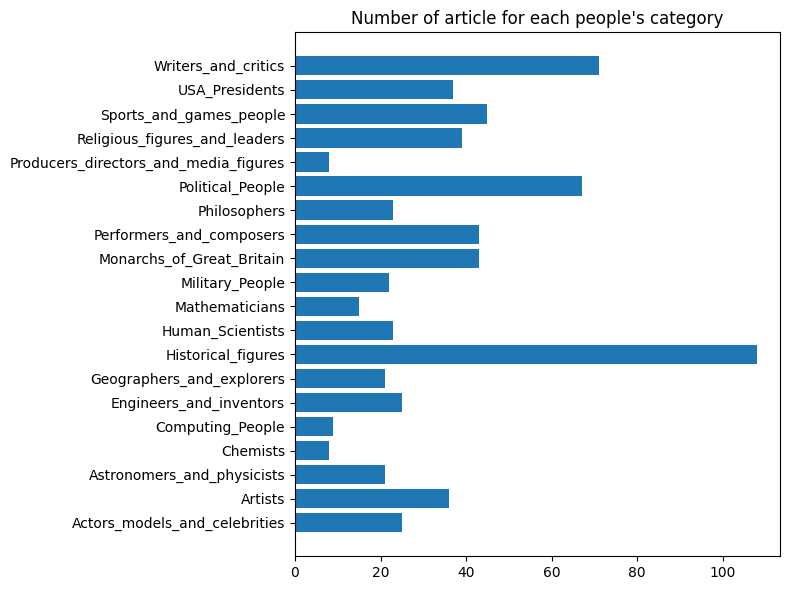

In [4]:
path = "./data/wikispeedia_paths-and-graph/wikispeedia_paths-and-graph/categories.tsv"

categories = pd.read_csv(path,header = 12, delimiter='\t',names=["article","categories"])
categories['article'] = categories['article'].apply(lambda x :(urllib.parse.unquote(x , encoding = 'utf-8'))) # Decode article names

people = categories[categories['categories'].str.contains('subject.People')].copy() # Dataset of people
people['categories'] = people['categories'].apply(lambda x : x[len('subject.People.'):]) # Remove useless string

#print(people.head())
#print(people.shape)
#print(people.categories.unique(),len(people.categories.unique()))
counts = people.groupby('categories').count()
counts = counts.reset_index()
counts.columns = ["Name", "Count"]
print(counts.head())

plt.figure(figsize=(8, 6))

plt.barh(counts["Name"], counts['Count'])
plt.title("Number of article for each people's category")
plt.xticks(rotation=0)
plt.tight_layout()

In [5]:
people["categories"]

0                  Historical_figures
3                             Artists
7                  Historical_figures
66            Sports_and_games_people
87                 Historical_figures
                    ...              
5187               Historical_figures
5189               Historical_figures
5190               Historical_figures
5196                 Political_People
5199    Religious_figures_and_leaders
Name: categories, Length: 689, dtype: object

c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


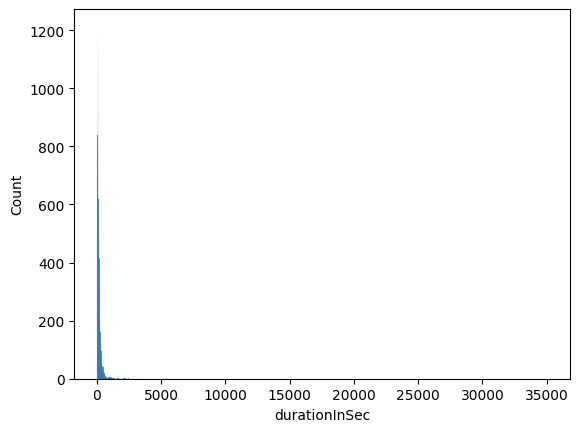

In [6]:
ax=sns.histplot(finished_path["durationInSec"], bins=10000)

c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0, 0.5, 'Duration [s]')

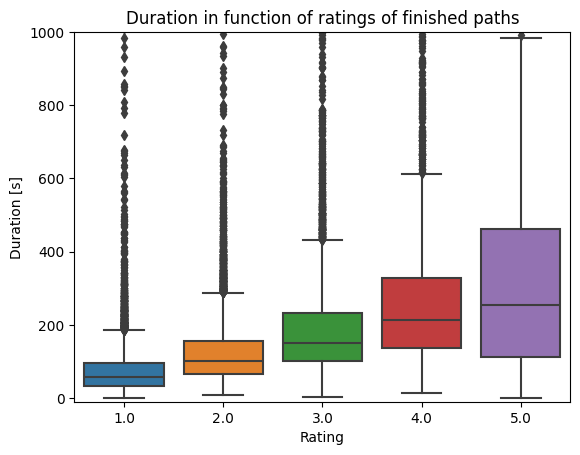

In [7]:

ax=sns.boxplot(x="rating", y="durationInSec", data=finished_path)
ax.set_ylim([-10,1000])
ax.set_title("Duration in function of ratings of finished paths")
ax.set_xlabel("Rating")
ax.set_ylabel("Duration [s]")


In [8]:
finished_path.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,2011-02-15 03:26:49,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,2012-08-12 06:36:52,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,2012-10-03 21:10:40,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,2013-04-23 15:27:08,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


Longest route in time: 91 pages


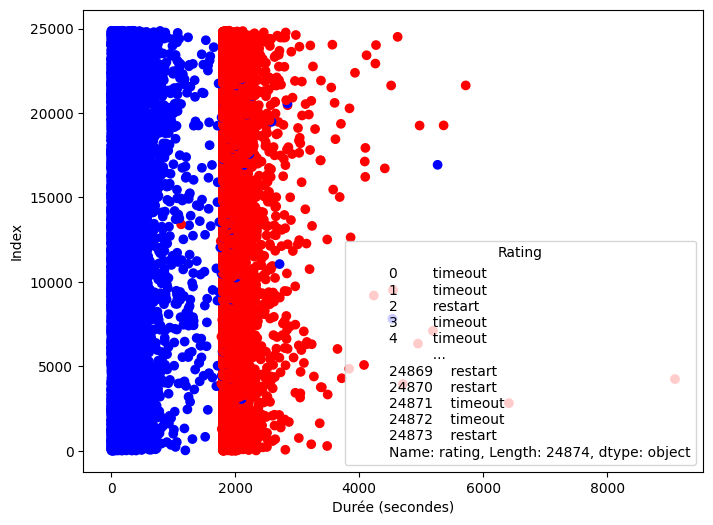

max duration for unfinished_path 151.48333333333332
max duration for finished_path 584.85


In [9]:
unfinished_path_duration = unfinished_path['durationInSec']
unfinished_path_rating = unfinished_path['rating']

max_duration_unfinished = max(unfinished_path_duration)
max_duration_finished = max(finished_path['durationInSec'])

max_duration_finished_id = finished_path.sort_values(by = 'durationInSec', ascending= False)
longest_trip = max_duration_finished_id.iloc[0]
print(f"Longest route in time: {len(longest_trip['path'])} pages")


plt.figure(figsize=(8, 6))
colors = {'timeout': 'red', 'restart': 'blue'}
plt.scatter(unfinished_path_duration, range(len(unfinished_path)), c=[colors[r] for r in unfinished_path_rating], label=unfinished_path_rating)

plt.xlabel('Durée (secondes)')
plt.ylabel('Index')
plt.legend(title='Rating')

plt.show()

print('max duration for unfinished_path', max_duration_unfinished/60)
print('max duration for finished_path', max_duration_finished/60)


I'm going to try to store the path pages and count how many of them are used on all the finished paths

In [10]:
finished_path.head()
#finished_path['path'] = finished_path['path'].apply(lambda x: x.split(';'))
finished_path


,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,2011-02-15 03:26:49,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,2012-08-12 06:36:52,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,2012-10-03 21:10:40,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,2010-02-08 07:25:25,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,2013-04-23 15:27:08,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0
...,...,...,...,...,...
51313,15a13a1d66ef5456,2012-10-03 02:23:35,66,Yagan;Ancient_Egypt;Civilization,NaN
51314,2ef7ac844cefda58,2011-03-16 05:42:18,165,Yagan;Folklore;Brothers_Grimm;<;19th_century;C...,3.0
51315,12863abb7887f890,2013-11-22 04:42:52,228,Yagan;Australia;England;France;United_States;T...,NaN
51316,19f8284371753362,2011-02-27 07:42:47,56,Yarralumla%2C_Australian_Capital_Territory;Aus...,1.0


In [11]:
def get_internal_paths(path_list):
    return path_list[1:-1]

In [12]:
# I concatenate everything into a single character string
all_paths = finished_path['path'].apply(lambda x: x.split(';'))

# i keep the start and end path
paths_flat = [path for sublist in all_paths for path in sublist]
paths_count = pd.Series(paths_flat).value_counts().to_dict()


# i get rid of the first and last element
internal_paths = all_paths.apply(lambda x: x[1:-1] if len(x) > 2 else [])
internal_paths_flat = [path for sublist in internal_paths for path in sublist]
internal_paths_count = pd.Series(internal_paths_flat).value_counts().to_dict()




print(paths_count)

print(internal_paths_count)
# i will now look at the hubs 

{'<': 20561, 'United_States': 8896, 'Europe': 4362, 'United_Kingdom': 3904, 'England': 3332, 'Earth': 3223, 'Africa': 2796, 'World_War_II': 2301, 'North_America': 1884, 'Germany': 1769, 'Animal': 1713, 'Human': 1642, 'Mammal': 1622, 'France': 1617, 'Computer': 1552, 'Science': 1497, 'English_language': 1430, 'Periodic_table': 1413, 'Brain': 1324, 'Atlantic_Ocean': 1324, 'Telephone': 1252, 'India': 1236, 'Bird': 1210, 'Viking': 1198, 'Agriculture': 1185, 'Plant': 1180, 'Asia': 1176, 'Asteroid': 1174, 'China': 1126, 'Christianity': 1097, 'Japan': 1086, 'United_Nations': 1064, 'Internet': 1047, 'Zebra': 1042, 'Theatre': 1038, 'Russia': 1019, 'Australia': 1003, 'Chemistry': 991, 'London': 976, 'Sun': 932, 'Canada': 922, 'South_America': 920, 'Water': 905, 'European_Union': 891, 'Adolf_Hitler': 883, 'Solar_System': 880, 'Italy': 867, 'President_of_the_United_States': 850, 'Physics': 848, 'Pacific_Ocean': 844, 'Chemical_element': 841, 'Computer_science': 834, 'Biology': 808, 'Mathematics': 8

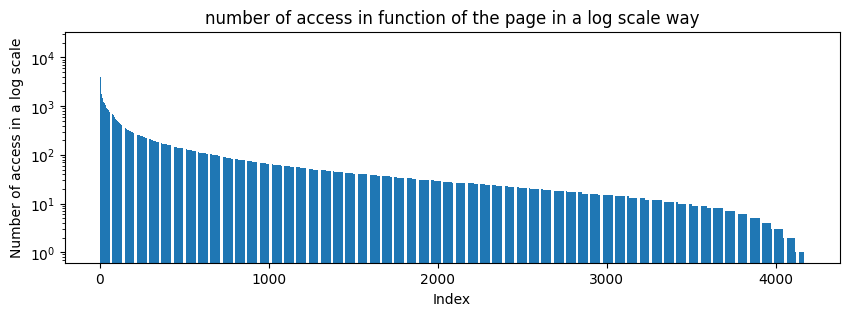

In [13]:

pages = list(paths_count.keys())
counts = list(paths_count.values())


plt.figure(figsize=(10, 3))
plt.bar(range(len(pages)), counts) 
plt.xlabel('Index')
plt.ylabel('Number of access in a log scale')
plt.yscale('log')
plt.title('number of access in function of the page in a log scale way')
plt.show()

In [14]:
# top 100 
top_100_fin_hubs = dict(sorted(paths_count.items(), key=lambda item: item[1], reverse=True)[:25])
top_100_fin_hubs

{'<': 20561,
 'United_States': 8896,
 'Europe': 4362,
 'United_Kingdom': 3904,
 'England': 3332,
 'Earth': 3223,
 'Africa': 2796,
 'World_War_II': 2301,
 'North_America': 1884,
 'Germany': 1769,
 'Animal': 1713,
 'Human': 1642,
 'Mammal': 1622,
 'France': 1617,
 'Computer': 1552,
 'Science': 1497,
 'English_language': 1430,
 'Periodic_table': 1413,
 'Brain': 1324,
 'Atlantic_Ocean': 1324,
 'Telephone': 1252,
 'India': 1236,
 'Bird': 1210,
 'Viking': 1198,
 'Agriculture': 1185}

Text(0.5, 1.0, 'Top 25 pages in path')

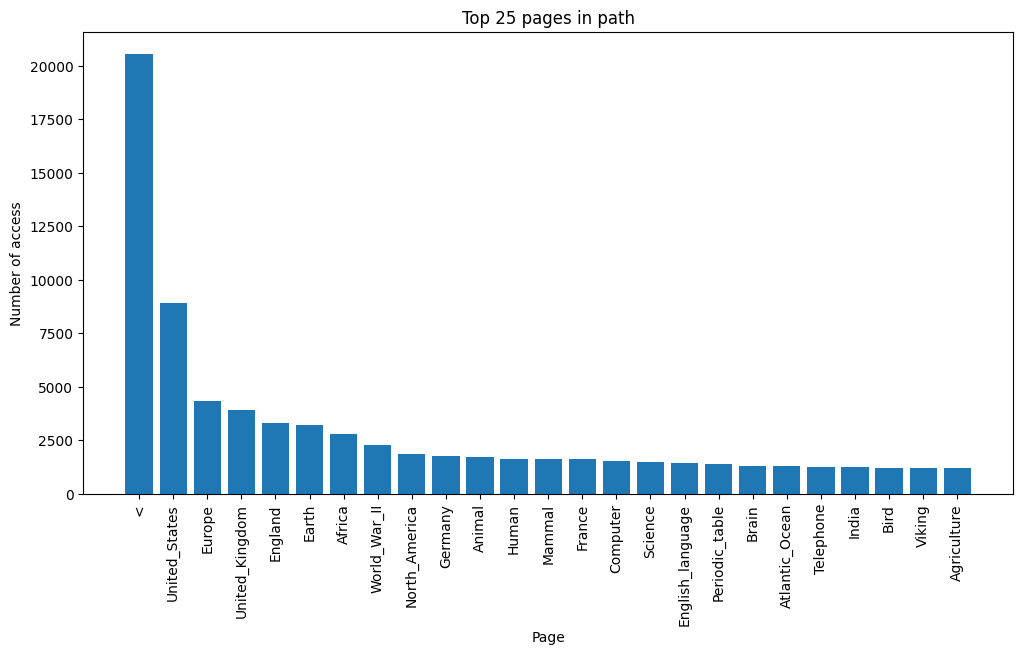

In [15]:
pages = list(top_100_fin_hubs.keys())
counts = list(top_100_fin_hubs.values())
# top 100 c'est trop grand --> top 25

plt.figure(figsize=(12, 6))
plt.bar(pages, counts) 
plt.xlabel('Page')
plt.ylabel('Number of access')
plt.xticks(rotation=90)
plt.title('Top 25 pages in path')

the first hub is the "<" button that is used to go back (like a ctrl z)

In [16]:
print('number of articles in wikispeedia :', len(paths_count))

number of articles in wikispeedia : 4170


In [17]:
title_of_all_articles = paths_count.keys()

## I will now classify the public figures:

In [18]:
import numpy as np

all_hubs = dict(sorted(paths_count.items(), key=lambda item: item[1], reverse=True))
all_hubs_internal = dict(sorted(internal_paths_count.items(), key=lambda item: item[1], reverse=True))
#print(all_hubs)
hubs_people = {key: value for key, value in all_hubs.items() if key in people['article'].tolist()}
hubs_political_people = {key: value for key, value in hubs_people.items() if key in people[people['categories'] == 'Political_People']['article'].tolist()}

hubs_people_internal = {key: value for key, value in all_hubs_internal.items() if key in people['article'].tolist()}
hubs_political_people_internal = {key: value for key, value in hubs_people_internal.items() if key in people[people['categories'] == 'Political_People']['article'].tolist()}



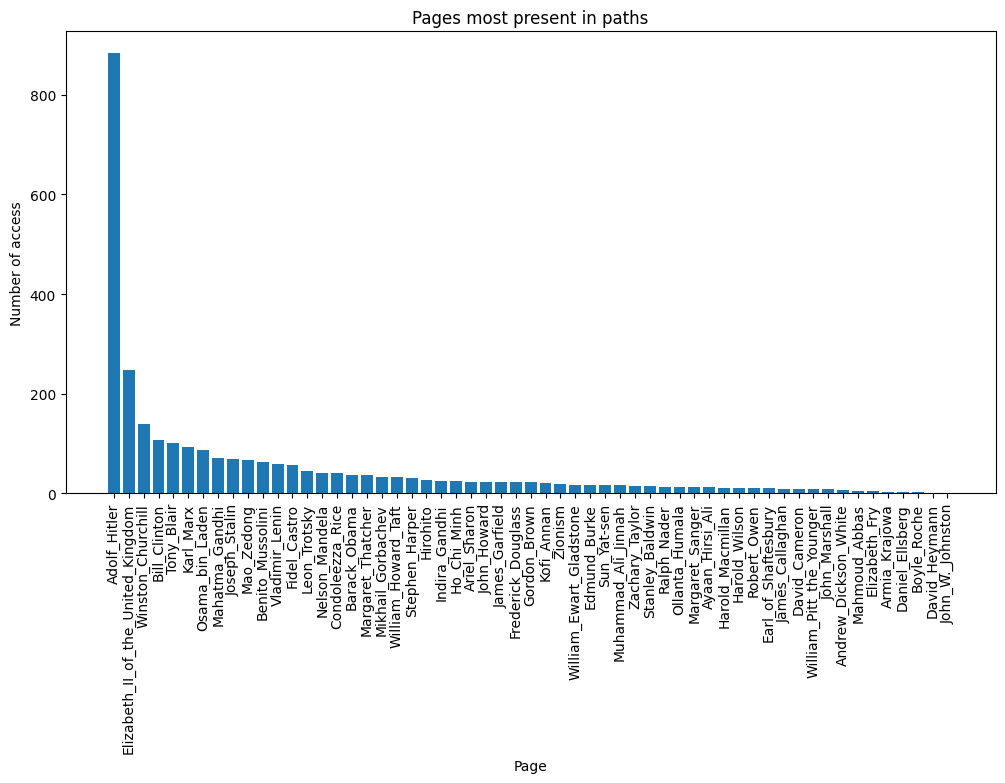

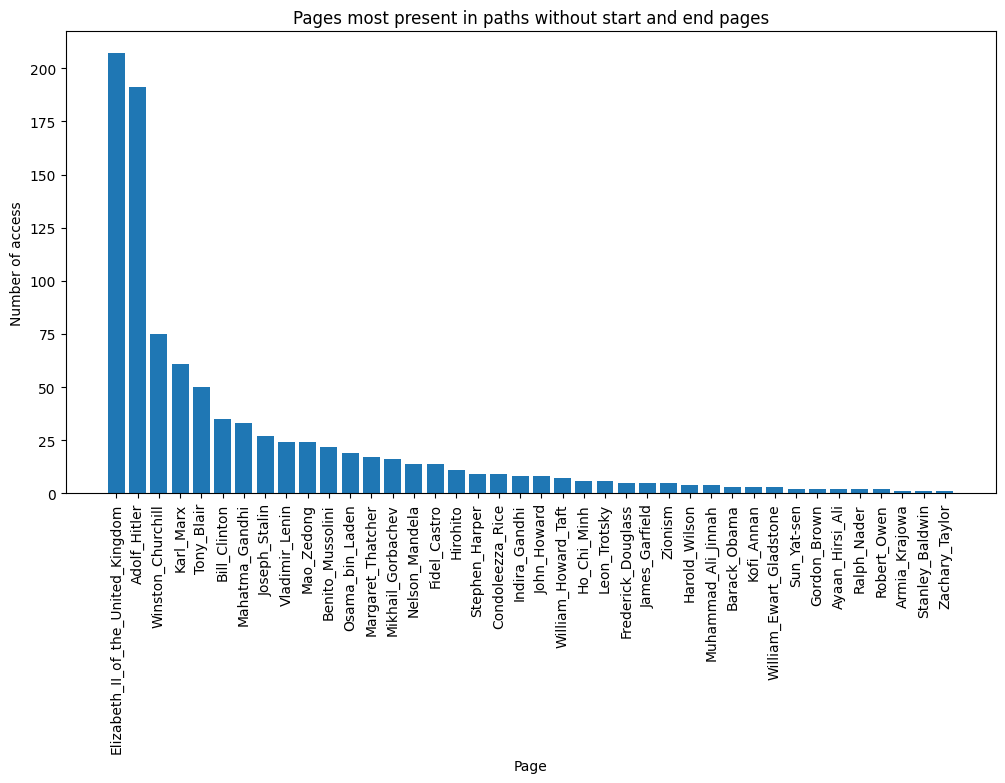

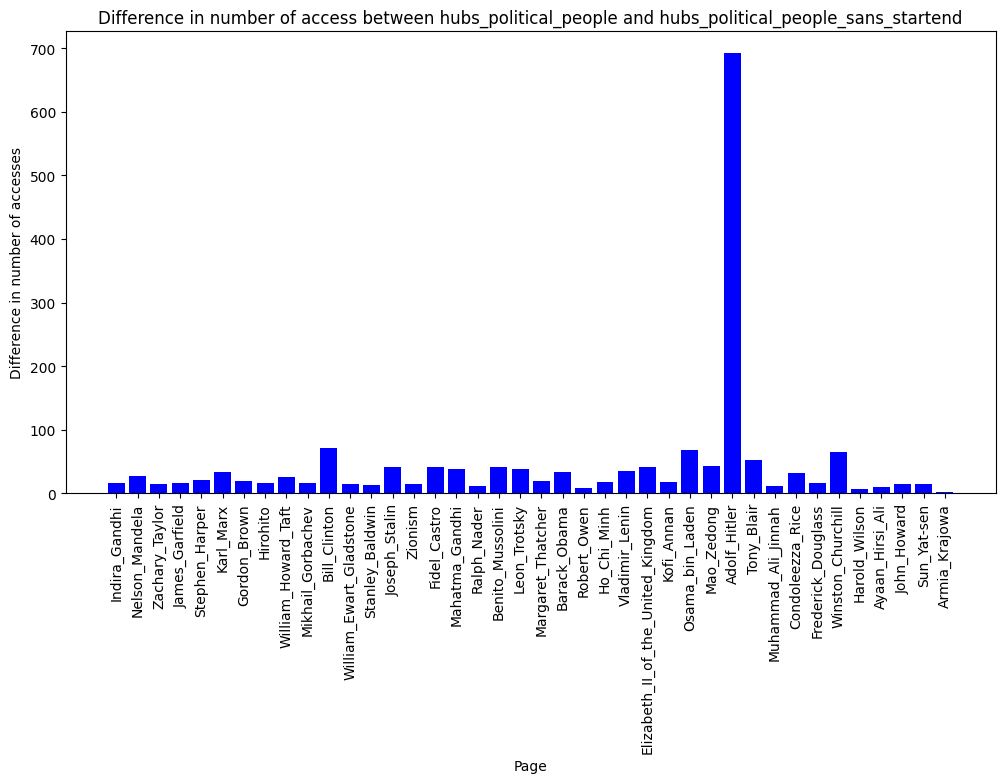

20.0


In [19]:
pages = list(hubs_political_people.keys())
counts = list(hubs_political_people.values())

plt.figure(figsize=(12, 6))
plt.bar(pages, counts) 
plt.xlabel('Page')
plt.ylabel('Number of access')
plt.xticks(rotation=90)
plt.title('Pages most present in paths')


pages2 = list(hubs_political_people_internal.keys())
counts2 = list(hubs_political_people_internal.values())


plt.figure(figsize=(12, 6))
plt.bar(pages2, counts2) 
plt.xlabel('Page')
plt.ylabel('Number of access')
plt.xticks(rotation=90)
plt.title('Pages most present in paths without start and end pages')

common_keys = set(hubs_political_people.keys()) & set(hubs_political_people_internal.keys())

diff_items = {key: hubs_political_people[key] - hubs_political_people_internal[key] for key in common_keys}

plt.figure(figsize=(12, 6))
plt.bar(diff_items.keys(), diff_items.values(), color='blue')
plt.xlabel('Page')
plt.ylabel('Difference in number of accesses')
plt.xticks(rotation=90)
plt.title('Difference in number of access between hubs_political_people and hubs_political_people_sans_startend')
plt.show()

diff_values = list(diff_items.values())
median_diff = np.median(diff_values)

print(median_diff)


In [20]:
path_diff_dict = {}

# i'm now making a dict that contains the diff in access between the paths and the internal paths
for key in paths_count:
    if key in internal_paths_count:
        path_diff_dict[key] = paths_count[key] - internal_paths_count[key]

sorted_diff = sorted(path_diff_dict.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_diff

[('Telephone', 1182),
 ('Brain', 1126),
 ('Viking', 1097),
 ('Asteroid', 1079),
 ('Zebra', 985),
 ('Theatre', 961),
 ('Pyramid', 720),
 ('Adolf_Hitler', 692),
 ('Bean', 691),
 ('Batman', 617),
 ('Jesus', 342),
 ('Bird', 300),
 ('God', 271),
 ('Sun', 252),
 ('Cat', 243),
 ('Computer', 227),
 ('Dog', 219),
 ('England', 209),
 ('Great_white_shark', 204),
 ('Wood', 201),
 ('China', 193),
 ('Banana', 172),
 ('Google', 169),
 ('Beer', 167),
 ('The_Holocaust', 164),
 ('Pluto', 162),
 ('Microsoft', 161),
 ('Water', 155),
 ('Hydrogen', 155),
 ('Nintendo', 146),
 ('Moon', 137),
 ('AIDS', 130),
 ('Apple', 129),
 ('Ocean', 126),
 ('George_W._Bush', 125),
 ('Canada', 121),
 ('Flower', 121),
 ('Cheese', 118),
 ('Bible', 116),
 ('Fruit', 115),
 ('Parrot', 115),
 ('Venus', 113),
 ('Penguin', 112),
 ('Electricity', 111),
 ('Vietnam', 111),
 ('Japan', 108),
 ('Music', 107),
 ('Brazil', 107),
 ('Automobile', 107),
 ('Windows_Vista', 107),
 ('Mars', 105),
 ('Dinosaur', 104),
 ('Africa', 103),
 ('Mario', 1

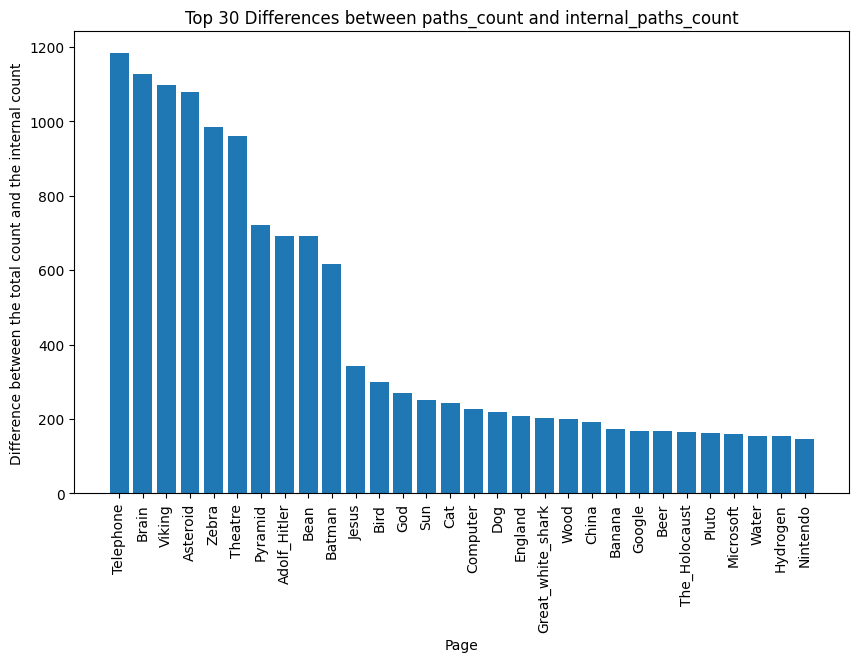

In [21]:
# i'm now doing a plot of the 30 first differences 
top_diff = sorted_diff[:30]
keys = [item[0] for item in top_diff]
values = [item[1] for item in top_diff]

plt.figure(figsize=(10, 6))
plt.bar(keys, values)
plt.xlabel('Page')
plt.ylabel('Difference between the total count and the internal count')
plt.title('Top 30 Differences between paths_count and internal_paths_count')
plt.xticks(rotation=90)  
plt.show()



### Classification des people

In [22]:
politicien = people[people['categories'] == 'Political_People']

politicien = politicien.drop(columns='categories')

print(politicien.to_string(index=False))

politicien

                                                              article
                                                         Adolf_Hitler
                                                 Andrew_Dickson_White
                                                         Ariel_Sharon
                                                        Armia_Krajowa
                                                      Ayaan_Hirsi_Ali
                                                         Barack_Obama
                                                     Benito_Mussolini
                          Benjamin_Disraeli,_1st_Earl_of_Beaconsfield
                                                         Bill_Clinton
                                                          Boyle_Roche
                                                     Condoleezza_Rice
                                                    Cyrus_K._Holliday
                                                      Daniel_Ellsberg
                    

,article
133,Adolf_Hitler
271,Andrew_Dickson_White
366,Ariel_Sharon
374,Armia_Krajowa
461,Ayaan_Hirsi_Ali
...,...
5074,William_Howard_Taft
5086,William_Pitt_the_Younger
5106,Winston_Churchill
5178,Zachary_Taylor


In [23]:
#politicien.loc[politicien['article'] == 'Osama_bin_Laden', 'political_affiliation'] = 'Right'

In [24]:
#politicien.head()

In [25]:
#politicien[politicien['political_affiliation'] == 'Left'].count()

In [26]:
politicien = pd.read_csv('./political_affiliation.csv', delimiter= ';')
politicien

,article,political_affiliation
0,Adolf_Hitler,Right
1,Andrew_Dickson_White,Right
2,Ariel_Sharon,Right
3,Armia_Krajowa,Right
4,Ayaan_Hirsi_Ali,Right
...,...,...
62,William_Howard_Taft,Right
63,William_Pitt_the_Younger,Right
64,Winston_Churchill,Right
65,Zachary_Taylor,Center


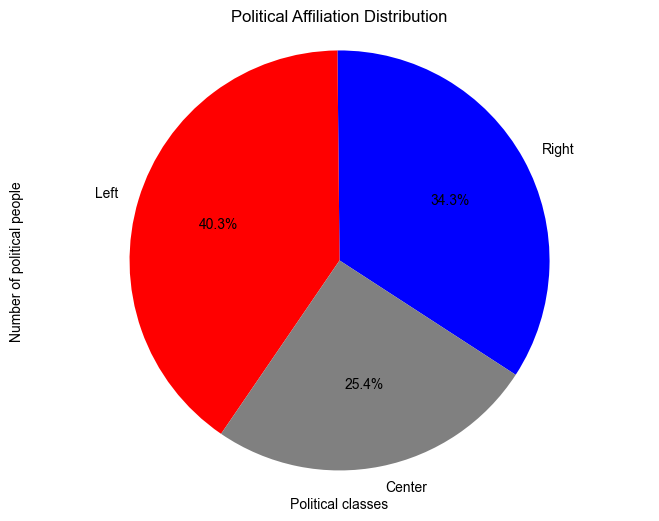

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

affiliation_counts = {"Right": 0, "Left": 0, "Center": 0}

for affiliation in politicien['political_affiliation']:
    if affiliation in affiliation_counts:
        affiliation_counts[affiliation] += 1

labels = list(affiliation_counts.keys())
sizes = list(affiliation_counts.values())
colors = ['blue', 'red', 'gray']

plt.figure(figsize=(8, 6))  
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=-33)
plt.xlabel('Political classes')
plt.ylabel('Number of political people')
plt.title('Political Affiliation Distribution')
plt.axis('equal')  
sns.set_context("talk")  
sns.set_style("whitegrid")  
plt.show()


### Stats on the political bias dataset

In [28]:
bias = pd.read_csv('political_bias.csv')
bias.drop('Unnamed: 0', axis=1, inplace=True)
bias.head()


,title,Bias
0,Áedán_mac_Gabráin,2
1,Åland,2
2,Édouard_Manet,0
3,Éire,2
4,Óengus_I_of_the_Picts,2


In [29]:
#categories.head()
df_categories = categories
df_categories.head(20)

,article,categories
0,Áedán_mac_Gabráin,subject.People.Historical_figures
1,Åland,subject.Countries
2,Åland,subject.Geography.European_Geography.European_...
3,Édouard_Manet,subject.People.Artists
4,Éire,subject.Countries
5,Éire,subject.Geography.European_Geography.European_...
6,Óengus_I_of_the_Picts,subject.History.British_History.British_Histor...
7,Óengus_I_of_the_Picts,subject.People.Historical_figures
8,€2_commemorative_coins,subject.Business_Studies.Currency
9,10th_century,subject.History.General_history


In [30]:
import pandas as pd

# Supprimer 'subject.' et créer un encodage one-hot pour les catégories
df_categories['categories'] = df_categories['categories'].str.replace('subject.', '')
encoded_categories = df_categories['categories'].str.get_dummies(sep='.')

# Concaténer l'encodage one-hot avec la colonne 'article'
categories_encoded = pd.concat([df_categories['article'], encoded_categories], axis=1)

# Combinaison des lignes en une seule ligne par article en additionnant les valeurs
categories_combined = categories_encoded.groupby('article').max().reset_index()

categories_combined.head()


,article,Actors_models_and_celebrities,African_Countries,African_Geography,Air_and_Sea_transport,Ancient_History_Classical_History_and_Mythology,Animal_and_Human_Rights,Antarctica,Archaeology,Architecture,...,Sports_events,Sports_teams,Storms,Television,The_Planets,Theatre,USA_Presidents,Websites_and_the_Internet,World_War_II,Writers_and_critics
0,10th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,13th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,14th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# i test just to see for which columns is there a 1 for the article Aland
aland_row = categories_combined[categories_combined['article'] == 'Åland']

columns_with_1 = aland_row.iloc[:, 1:].eq(1).any()

column_names_with_1 = columns_with_1[columns_with_1].index.tolist()
print(column_names_with_1)


['Countries', 'European_Countries', 'European_Geography', 'Geography']


In [32]:
# now i'm merging the categories_combined df with the political bias df 

all_articles_with_bias_and_categories = pd.merge(categories_combined, bias, left_on = 'article', right_on = 'title', how = 'left')
all_articles_with_bias_and_categories = all_articles_with_bias_and_categories.drop('title', axis = 1)


In [33]:
all_articles_with_bias_and_categories.head()

,article,Actors_models_and_celebrities,African_Countries,African_Geography,Air_and_Sea_transport,Ancient_History_Classical_History_and_Mythology,Animal_and_Human_Rights,Antarctica,Archaeology,Architecture,...,Sports_teams,Storms,Television,The_Planets,Theatre,USA_Presidents,Websites_and_the_Internet,World_War_II,Writers_and_critics,Bias
0,10th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,13th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,14th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


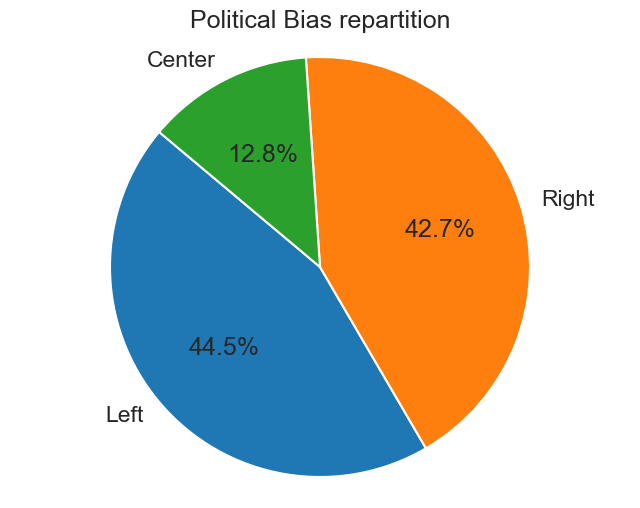

In [34]:
bias_counts = bias['Bias'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(bias_counts, labels=['Left','Right','Center'], autopct='%1.1f%%', startangle=140)
plt.title('Political Bias repartition')
plt.axis('equal') 
plt.show()

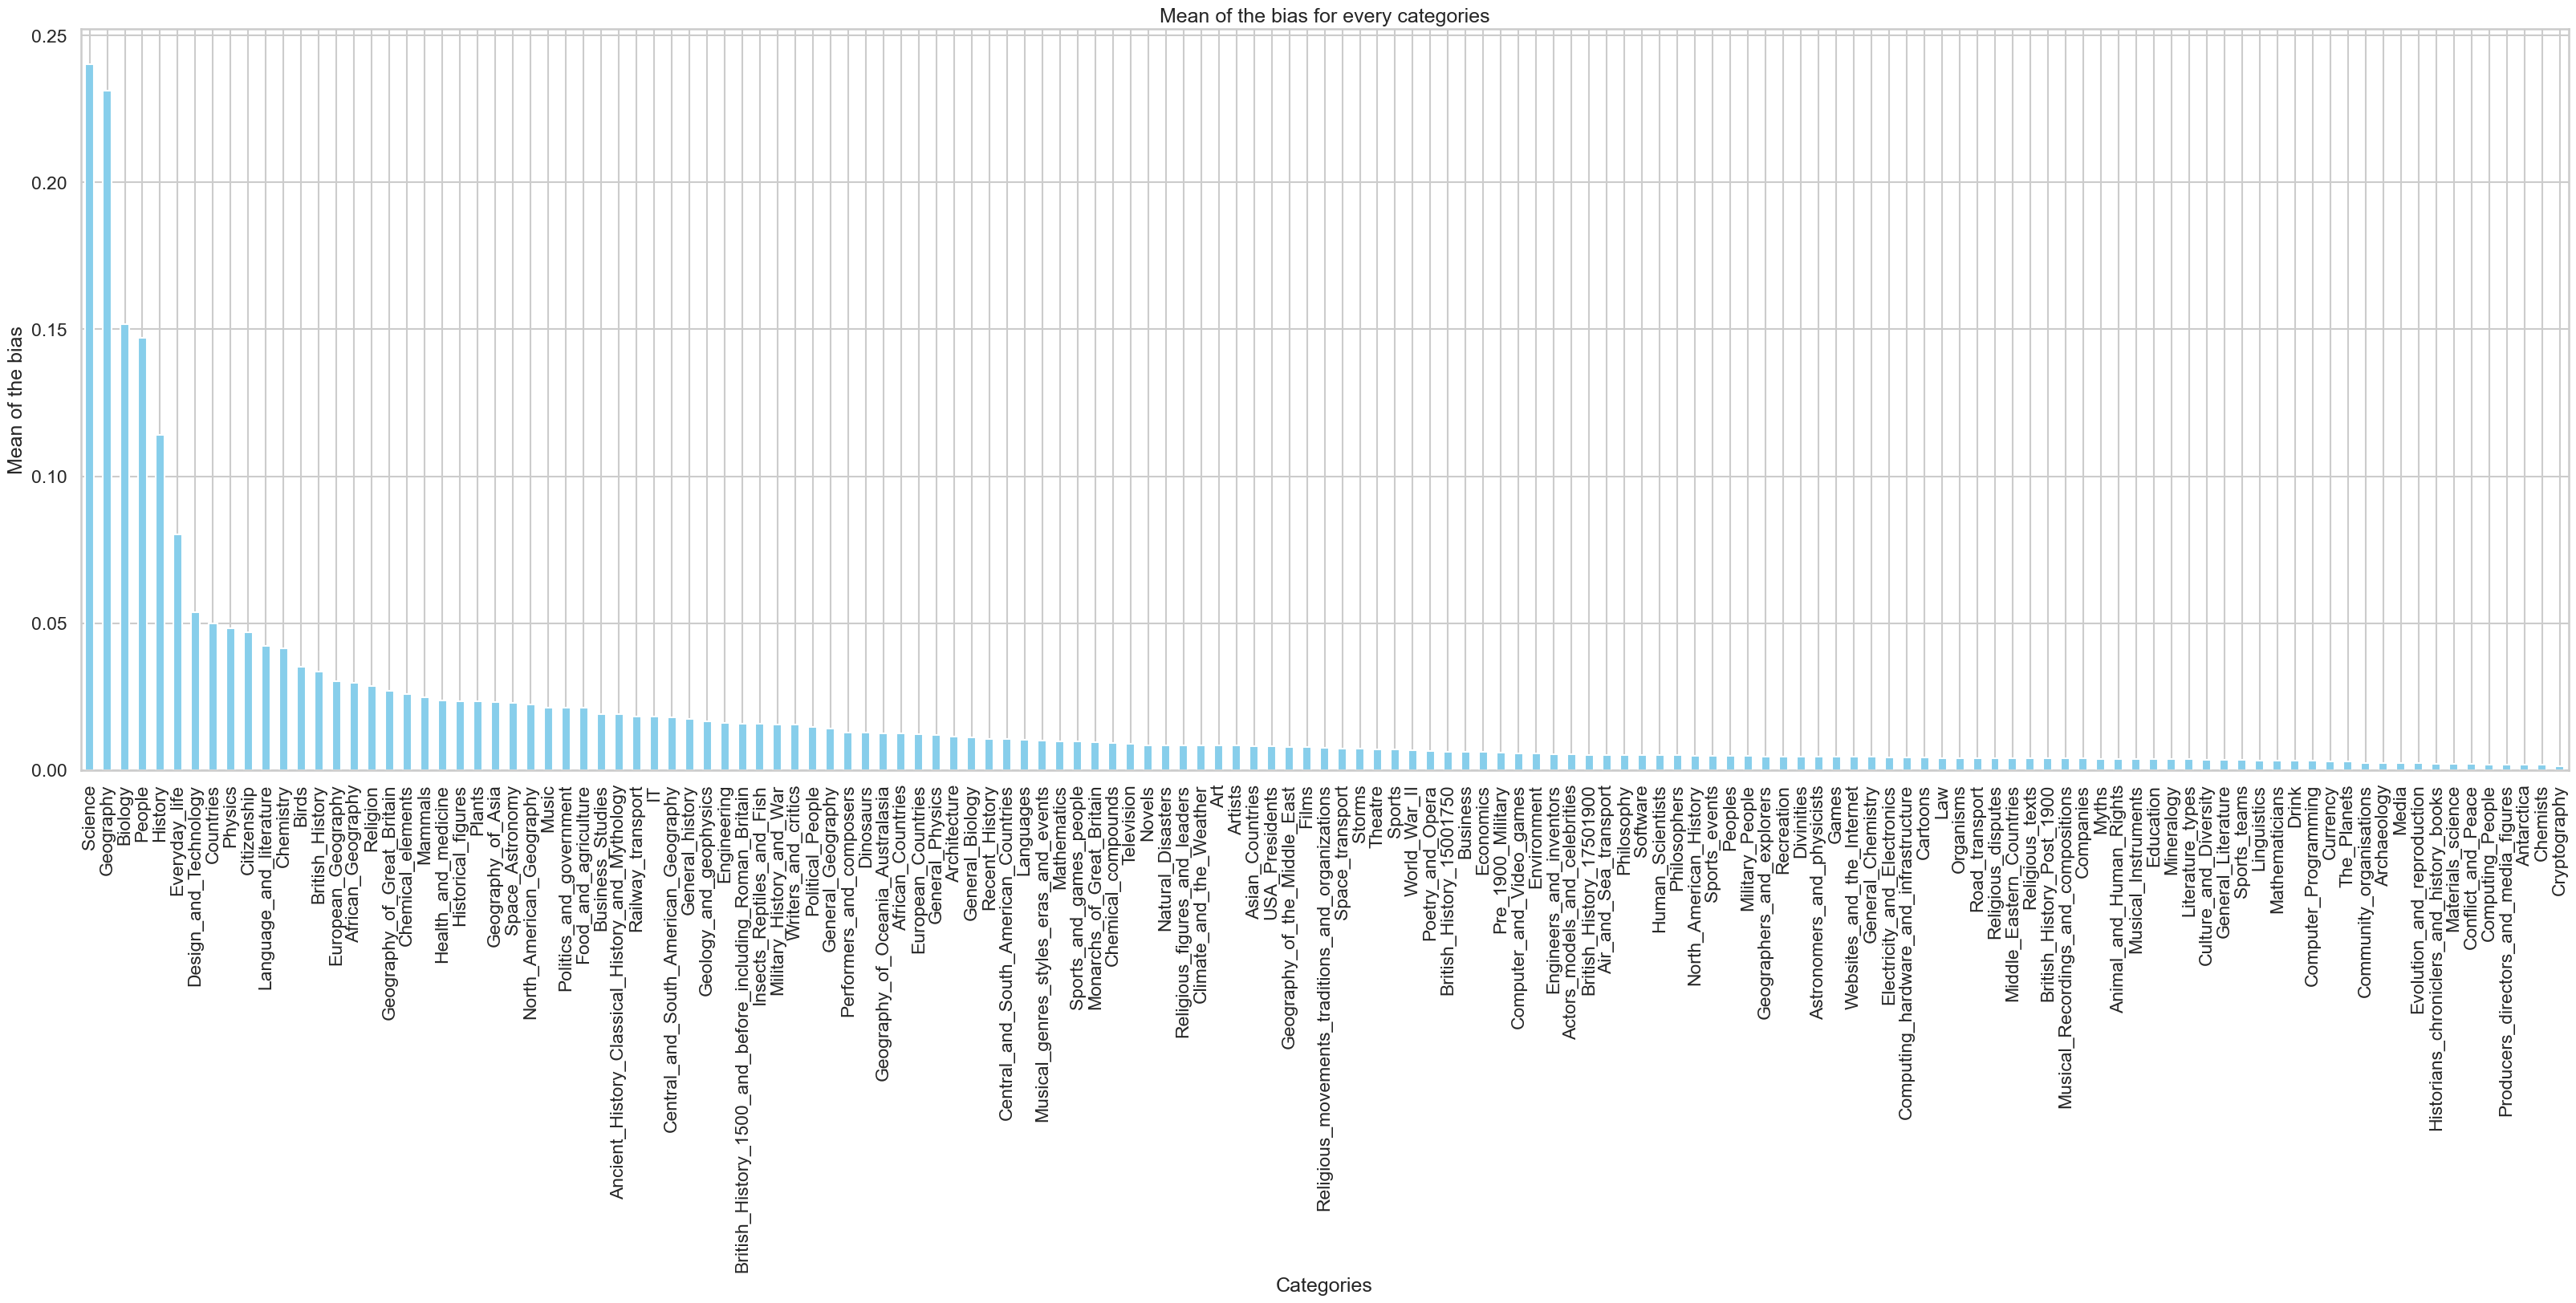

In [35]:
categories = all_articles_with_bias_and_categories.drop(['article', 'Bias'], axis=1)

categories.mean().sort_values(ascending=False).plot(kind='bar', figsize=(40, 12), color='skyblue')
plt.title('Mean of the bias for every categories')
plt.xlabel('Categories')
plt.ylabel('Mean of the bias')
plt.xticks(rotation=90)
plt.show()

In [40]:
all_articles_with_bias_and_categories.head()

,article,Actors_models_and_celebrities,African_Countries,African_Geography,Air_and_Sea_transport,Ancient_History_Classical_History_and_Mythology,Animal_and_Human_Rights,Antarctica,Archaeology,Architecture,...,Sports_teams,Storms,Television,The_Planets,Theatre,USA_Presidents,Websites_and_the_Internet,World_War_II,Writers_and_critics,Bias
0,10th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,11th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,13th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
4,14th_century,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [53]:
all_articles_with_bias_and_categories_transposed = all_articles_with_bias_and_categories.T

In [57]:
# pick out the biases, could also be possible with the bias df 
biases = all_articles_with_bias_and_categories_transposed.iloc[-1]

category_to_articles_with_bias = {}

#iterate throughs every row except bias that is the last one --> :-1
for category in all_articles_with_bias_and_categories_transposed.index[:-1]:
    articles_in_category = all_articles_with_bias_and_categories_transposed.loc[category][all_articles_with_bias_and_categories_transposed.loc[category] == 1]
    articles_bias = biases[articles_in_category.index]
    articles_with_bias = list(zip(articles_in_category.index, articles_bias))
    category_to_articles_with_bias[category] = articles_with_bias

"""
for category, articles_with_bias in category_to_articles_with_bias.items():
    print(f"Catégorie : {category}")
    for article, bias in articles_with_bias:
        print(f"Article : {article}, Bias : {bias}")
    print("\n")
"""

'\nfor category, articles_with_bias in category_to_articles_with_bias.items():\n    print(f"Catégorie : {category}")\n    for article, bias in articles_with_bias:\n        print(f"Article : {article}, Bias : {bias}")\n    print("\n")\n'

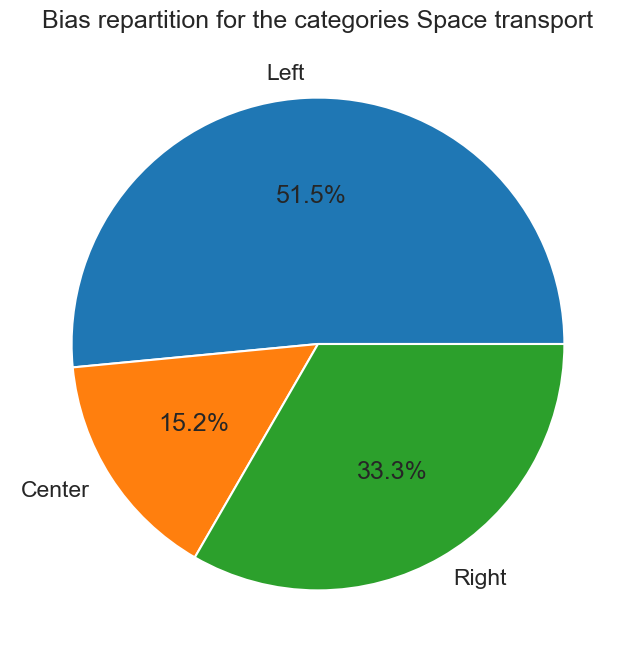

In [87]:
space_trans_cat = category_to_articles_with_bias['Space_transport']

space_trans_cat
biases = [bias for _, bias in space_trans_cat]
bias_counts = {0: 0, 1: 0, 2: 0}
for _, bias in space_trans_cat:
    bias_counts[bias] += 1
    labels = ['Left', 'Center', 'Right']
sizes = [bias_counts[0], bias_counts[1], bias_counts[2]]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Bias repartition for the categories Space transport')
plt.show()

In [95]:
for category, articles_with_bias  in category_to_articles_with_bias.items():
    biases = [bias for _, bias in articles_with_bias]
    bias_counts = {0: 0, 1: 0, 2: 0}
    for _, bias in articles_with_bias:
        bias_counts[bias] += 1
        labels = ['Left', 'Center', 'Right']
    sizes = [bias_counts[0], bias_counts[1], bias_counts[2]]

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%')
    plt.title('Bias repartition for the categories Space transport')
    plt.show()  

c:\Users\Admin\miniconda3\envs\ada\lib\site-packages\matplotlib\axes\_axes.py:3229: RuntimeWarning: invalid value encountered in divide
  x = x / sx


ValueError: cannot convert float NaN to integer

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ValueError: need at least one array to concatenate

<Figure size 800x800 with 1 Axes>